In [25]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns


In [2]:
import xgboost as xgb


In [3]:
strategy_data_path = '../simulated_data/precalculated_metrics/all_strategy_metrics.csv'



strategy_df = pd.read_csv(strategy_data_path)
strategy_df['strategy_name'] = strategy_df['strategy_name'].str.strip()
strategy_df.fillna(0, inplace=True)



In [4]:
strategy_metrics = {}
for idx, row in strategy_df.iterrows():
    strategy_metrics[row['strategy_name']] = row[['Niceness','Retaliation','Forgiveness','OverallCoop','AvgPayoff']].to_dict()
strategy_metrics

{'AON2': {'Niceness': 1.0,
  'Retaliation': 0.9048521929553368,
  'Forgiveness': 0.0,
  'OverallCoop': 0.7136381578947368,
  'AvgPayoff': 2.780519736842105},
 'APavlov2006': {'Niceness': 1.0,
  'Retaliation': 0.9390716795754448,
  'Forgiveness': 0.6761810193666269,
  'OverallCoop': 0.7605460526315789,
  'AvgPayoff': 2.685269736842105},
 'APavlov2011': {'Niceness': 1.0,
  'Retaliation': 0.8813740142375256,
  'Forgiveness': 0.7037723127823626,
  'OverallCoop': 0.7787105263157895,
  'AvgPayoff': 2.683236842105263},
 'Adaptive': {'Niceness': 1.0,
  'Retaliation': 0.0824213218120346,
  'Forgiveness': 0.0673076923076923,
  'OverallCoop': 0.496781954887218,
  'AvgPayoff': 2.2391870300751884},
 'AdaptiveTitForTat': {'Niceness': 1.0,
  'Retaliation': 0.9346153846153846,
  'Forgiveness': 1.0,
  'OverallCoop': 0.8340404135338345,
  'AvgPayoff': 2.7257857142857147},
 'Aggravater': {'Niceness': 0.0,
  'Retaliation': 1.0,
  'Forgiveness': 0.0,
  'OverallCoop': 0.0897744360902255,
  'AvgPayoff': 1.86

In [5]:
strategies = [axl.Raider(),axl.Cooperator(), axl.GrudgerAlternator(), axl.EvolvedANNNoise05(), axl.Forgiver(), axl.DefectorHunter(), axl.Prober2(), axl.SecondByColbert(), axl.SneakyTitForTat(), axl.SecondByRichardHufford()]


In [6]:
strategy_order = [player.__class__.__name__ for player in strategies]

strategy_mapping = {name: player.__class__ for name, player in zip(strategy_order, strategies)}

strategy_mapping

{'Raider': axelrod.strategies.finite_state_machines.Raider,
 'Cooperator': axelrod.strategies.cooperator.Cooperator,
 'GrudgerAlternator': axelrod.strategies.grudger.GrudgerAlternator,
 'EvolvedANNNoise05': axelrod.strategies.ann.EvolvedANNNoise05,
 'Forgiver': axelrod.strategies.forgiver.Forgiver,
 'DefectorHunter': axelrod.strategies.hunter.DefectorHunter,
 'Prober2': axelrod.strategies.prober.Prober2,
 'SecondByColbert': axelrod.strategies.axelrod_second.SecondByColbert,
 'SneakyTitForTat': axelrod.strategies.titfortat.SneakyTitForTat,
 'SecondByRichardHufford': axelrod.strategies.axelrod_second.SecondByRichardHufford}

In [8]:
MAX_COUNT = 10          # each strategy appears between 0 and 5 times
NUM_TOTAL_COMPS = (MAX_COUNT+1) ** len(strategy_order)  # 6^5 = 7776
NUM_SIMULATIONS = 30000   # number of tournaments to simulate (sampled from all compositions)
TOURNS = 200           # turns per tournament
REPETITIONS = 1     # repetitions per tournament


def get_tournament_winners_by_score(results, players, use_normalised=True):
    if use_normalised:
        if hasattr(results.normalised_scores, "compute"):
            scores_matrix = np.array(results.normalised_scores.compute())
        else:
            scores_matrix = np.array(results.normalised_scores)
    else:
        if hasattr(results.scores, "compute"):
            scores_matrix = np.array(results.scores.compute())
        else:
            scores_matrix = np.array(results.scores)
    average_scores = [np.mean(scores) for scores in scores_matrix]
    score_dict = {player.__class__.__name__: avg for player, avg in zip(players, average_scores)}
    print("Average scores:", score_dict)
    max_score = max(average_scores)
    winners = [
        player.__class__.__name__ for player, avg in zip(players, average_scores)
        if abs(avg - max_score) < 0.001
    ]
    unique_winners = []
    for w in winners:
        if w not in unique_winners:
            unique_winners.append(w)
    print("Winners for this tournament:", unique_winners, "\n")
    return unique_winners

def run_single_tournament(composition, turns=TOURNS, repetitions=REPETITIONS):
    players = []
    for count, strat_name in zip(composition, strategy_order):
        for _ in range(count):
            players.append(strategy_mapping[strat_name]())
    print("Tournament composition:", composition)
    tourn = axl.Tournament(players, turns=turns, repetitions=repetitions)
    results_tourn = tourn.play()
    coop_matrix = results_tourn.cooperation
    total_cooperations = sum(sum(row) for row in coop_matrix)
    total_moves = len(coop_matrix) ** 2 * repetitions
    coop_rate = total_cooperations / total_moves if total_moves > 0 else 0.0
    winners = get_tournament_winners_by_score(results_tourn, players)
    return {
        "composition": composition,
        "coop_rate": coop_rate,
        "winning_strategy": winners
    }


In [9]:
df_experiments = pd.read_csv('../simulated_data/simulated_tournamets/10_setup_data.csv.csv')

In [10]:
print(df_experiments.head())

                      composition   coop_rate       winning_strategy
0  [5, 1, 4, 4, 1, 5, 0, 2, 5, 3]  146.286667  ['EvolvedANNNoise05']
1  [1, 3, 3, 0, 1, 2, 1, 0, 5, 1]  151.754325             ['Raider']
2  [3, 3, 0, 5, 1, 4, 4, 3, 5, 3]  159.535900  ['EvolvedANNNoise05']
3  [1, 2, 4, 1, 2, 1, 2, 1, 0, 2]  157.949219             ['Raider']
4  [4, 5, 1, 5, 2, 0, 3, 0, 2, 5]  147.618656  ['EvolvedANNNoise05']


In [11]:
df_experiments['winning_strategy'] = df_experiments['winning_strategy'].apply(ast.literal_eval)
df_experiments['composition'] = df_experiments['composition'].apply(ast.literal_eval)



In [12]:
def build_tournament_feature_matrix(record, strategy_order, strategy_metrics):
    comp = record['composition']
    features = []
    for strat_name, count in zip(strategy_order, comp):
        if int(count) > 0:
            m = strategy_metrics.get(strat_name,
                                     {'Niceness':0, 'Retaliation':0, 'Forgiveness':0, 'OverallCoop':0, 'AvgPayoff':0})
            row = [count, m['Niceness'], m['Retaliation'], m['Forgiveness'], m['OverallCoop'], m['AvgPayoff']]
        else:
            row = [0, 0, 0, 0, 0, 0]
        features.append(row)
    return np.array(features)

tournament_features = []
for idx, row in df_experiments.iterrows():
    mat = build_tournament_feature_matrix(row, strategy_order, strategy_metrics)
    tournament_features.append(mat.flatten())



In [13]:
print(len(tournament_features[0]))

60


In [14]:
X = np.array(tournament_features)
coop_rate = df_experiments['coop_rate'].values.reshape(-1, 1)
print(df_experiments['winning_strategy'].value_counts())
X = np.concatenate([X, coop_rate], axis=1)
print("Final feature shape (each sample flattened):", X.shape)

winning_strategy
[EvolvedANNNoise05]                                          16474
[Raider]                                                      4423
[SecondByRichardHufford]                                      4061
[GrudgerAlternator]                                           2375
[SneakyTitForTat]                                             1637
[DefectorHunter]                                               604
[Forgiver]                                                      85
[EvolvedANNNoise05, SecondByRichardHufford]                     82
[Raider, EvolvedANNNoise05]                                     68
[SecondByColbert]                                               50
[Cooperator, DefectorHunter]                                    35
[Raider, SecondByRichardHufford]                                18
[GrudgerAlternator, EvolvedANNNoise05]                          17
[EvolvedANNNoise05, SneakyTitForTat]                            10
[GrudgerAlternator, SecondByRichardHufford]  

In [15]:
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(df_experiments['winning_strategy'])
print("Multi-label target shape:", y_multi.shape)
print("Classes (winning strategies):", mlb.classes_)

Multi-label target shape: (30000, 10)
Classes (winning strategies): ['Cooperator' 'DefectorHunter' 'EvolvedANNNoise05' 'Forgiver'
 'GrudgerAlternator' 'Prober2' 'Raider' 'SecondByColbert'
 'SecondByRichardHufford' 'SneakyTitForTat']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:

from sklearn.multiclass import OneVsRestClassifier

dt_clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=42, max_depth=5))
dt_clf.fit(X_train, y_train)
rf_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=300, random_state=42))
rf_clf.fit(X_train, y_train)
import xgboost as xgb
xgb_clf = OneVsRestClassifier(xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
xgb_clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:07:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [03:07:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [18]:
from tensorflow.keras.regularizers import l2
nn_model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='sigmoid')
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.4284 - loss: 0.4401 - val_accuracy: 0.7506 - val_loss: 0.1681
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.6910 - loss: 0.1893 - val_accuracy: 0.8269 - val_loss: 0.1276
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.7613 - loss: 0.1519 - val_accuracy: 0.8508 - val_loss: 0.1119
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.7807 - loss: 0.1398 - val_accuracy: 0.8612 - val_loss: 0.1042
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.8037 - loss: 0.1290 - val_accuracy: 0.8875 - val_loss: 0.0958
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.8125 - loss: 0.1231 - val_accuracy: 0.8921 - val_loss: 0.0920
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8236 - loss: 0.1192 - val_accuracy: 0.8869 - val_loss: 0.0888
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8239 - loss: 0.1156 - val_accurac

In [19]:
from sklearn.metrics import f1_score, roc_auc_score, hamming_loss, accuracy_score
import numpy as np
import pandas as pd

def evaluate_multilabel(model, X_test, y_test, name):
    if hasattr(model, "predict_proba"):
        y_prob = np.column_stack([clf.predict_proba(X_test)[:, 1]
                                  for clf in model.estimators_])
    else:                                          
        dec = model.decision_function(X_test)
        y_prob = 1 / (1 + np.exp(-dec))           

    y_pred = (y_prob > 0.5).astype(int)

    metrics = {
        "model":          name,
        "F1-micro":       f1_score(y_test, y_pred, average="micro"),
        "F1-macro":       f1_score(y_test, y_pred, average="macro"),
        "ROC-AUC-micro":  roc_auc_score(y_test, y_prob, average="micro"),
        "ROC-AUC-macro":  roc_auc_score(y_test, y_prob, average="macro"),
        "Hamming loss":   hamming_loss(y_test, y_pred),
        "Exact-match":    accuracy_score(y_test, y_pred),
    }
    return metrics


rf_metrics  = evaluate_multilabel(rf_clf, X_test, y_test, "Random-Forest")

xgb_metrics = evaluate_multilabel(xgb_clf, X_test, y_test, "XGBoost")
y_prob_nn = nn_model.predict(X_test, verbose=0)
y_pred_nn = (y_prob_nn > 0.5).astype(int)
nn_metrics = {
    "model":          "Neural-Net",
    "F1-micro":       f1_score(y_test, y_pred_nn, average="micro"),
    "F1-macro":       f1_score(y_test, y_pred_nn, average="macro"),
    "ROC-AUC-micro":  roc_auc_score(y_test, y_prob_nn, average="micro"),
    "ROC-AUC-macro":  roc_auc_score(y_test, y_prob_nn, average="macro"),
    "Hamming loss":   hamming_loss(y_test, y_pred_nn),
    "Exact-match":    accuracy_score(y_test, y_pred_nn),
}
results_df = pd.DataFrame([rf_metrics, xgb_metrics, nn_metrics])
print("\n=== Multi-label performance on held-out test set ===")
display(results_df.round(3))



=== Multi-label performance on held-out test set ===


,model,F1-micro,F1-macro,ROC-AUC-micro,ROC-AUC-macro,Hamming loss,Exact-match
0,Random-Forest,0.874,0.604,0.995,0.943,0.024,0.824
1,XGBoost,0.926,0.710,0.998,0.996,0.015,0.877
2,Neural-Net,0.941,0.505,0.998,0.979,0.012,0.913


Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.8964 - loss: 0.0777 - val_accuracy: 0.9492 - val_loss: 0.0528
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.9002 - loss: 0.0755 - val_accuracy: 0.9415 - val_loss: 0.0529
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.8893 - loss: 0.0790 - val_accuracy: 0.9485 - val_loss: 0.0522
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8979 - loss: 0.0776 - val_accuracy: 0.9481 - val_loss: 0.0523
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.9014 - loss: 0.0761 - val_accuracy: 0.9427 - val_loss: 0.0514
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.8973 - loss: 0.0778 - val_accuracy: 0.9519 - val_loss: 0.0514
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.8954 - loss: 0.0783 - val_accuracy: 0.9377 - val_loss: 0.0527
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.9001 - loss: 0.0771 - 

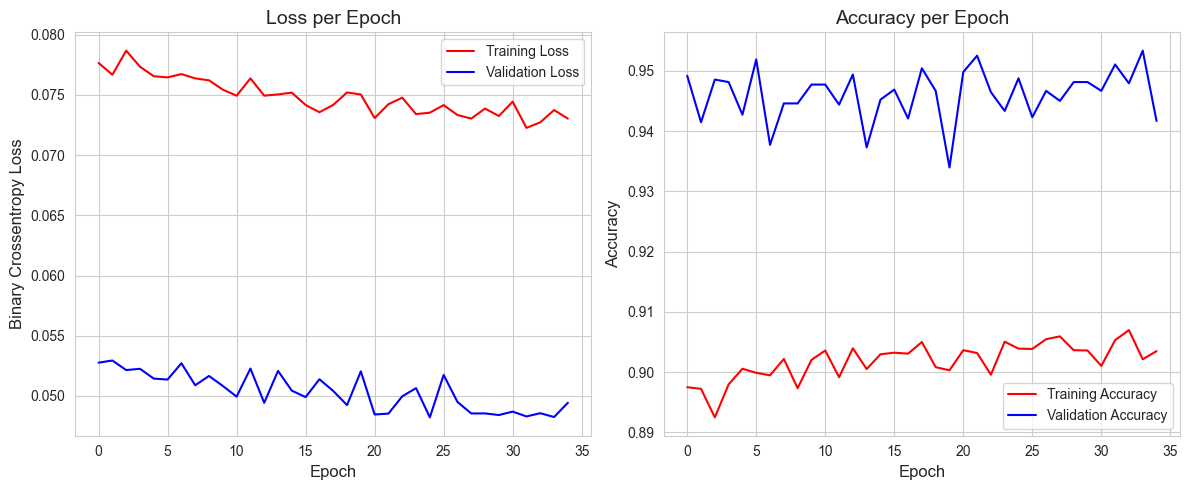

In [26]:
history = nn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.20,
    callbacks=[early_stop],
    verbose=1
)

import seaborn as sns

sns.set_style("whitegrid")

train_color = "red"
val_color = "blue"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['loss'], label='Training Loss', color=train_color)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color=val_color)
axes[0].set_title('Loss per Epoch', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Binary Crossentropy Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['accuracy'], label='Training Accuracy', color=train_color)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color=val_color)
axes[1].set_title('Accuracy per Epoch', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

In [20]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    multilabel_confusion_matrix
)
import seaborn as sns

def analyse_multilabel(y_true, y_pred, class_names,
                       title_prefix="Model"):
    p, r, f1, s = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    df_report = (pd.DataFrame({
        "precision": p,
        "recall"   : r,
        "f1"       : f1,
        "support"  : s
    }, index=class_names)
      .round(3)
      .sort_values("support", ascending=False)
    )
    display(df_report.style.background_gradient(cmap="Blues"))

    cm_all = multilabel_confusion_matrix(y_true, y_pred)
    n_cols = 3                              
    n_lab  = len(class_names)
    n_rows = int(np.ceil(n_lab / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4*n_cols, 4*n_rows),
                             constrained_layout=True)

    axes = axes.flatten()
    for i, (cm, ax) in enumerate(zip(cm_all, axes)):
        if i >= n_lab:                        
            ax.axis("off");  continue
        tn, fp, fn, tp = cm.ravel()
        sns.heatmap([[tp, fp], [fn, tn]],
            annot=True, fmt="d", cbar=False,
            cmap="YlGnBu", ax=ax,
            annot_kws={"size": 19})   
        ax.set_title(class_names[i])
        ax.set_xlabel("Predicted");  ax.set_ylabel("Actual")
        ax.set_xticklabels(["Pos", "Neg"]);  ax.set_yticklabels(["Pos", "Neg"])

    fig.suptitle(f"{title_prefix} – per-label confusion matrices",
                 fontsize=14, y=1.02)
    plt.show()

    return df_report 

In [21]:
def ovr_proba_to_matrix(proba):
    if isinstance(proba, list):                              
        return np.column_stack([p[:, 1] for p in proba])
    else:                                                    
        return proba

,precision,recall,f1,support
EvolvedANNNoise05,0.911000,0.956000,0.933000,3350
Raider,0.922000,0.727000,0.813000,910
SecondByRichardHufford,0.898000,0.701000,0.788000,846
GrudgerAlternator,0.924000,0.698000,0.795000,450
SneakyTitForTat,0.924000,0.683000,0.786000,338
DefectorHunter,0.925000,0.587000,0.718000,126
Forgiver,0.750000,0.200000,0.316000,15
Cooperator,1.000000,0.417000,0.588000,12
SecondByColbert,1.000000,0.182000,0.308000,11
Prober2,0.000000,0.000000,0.000000,1


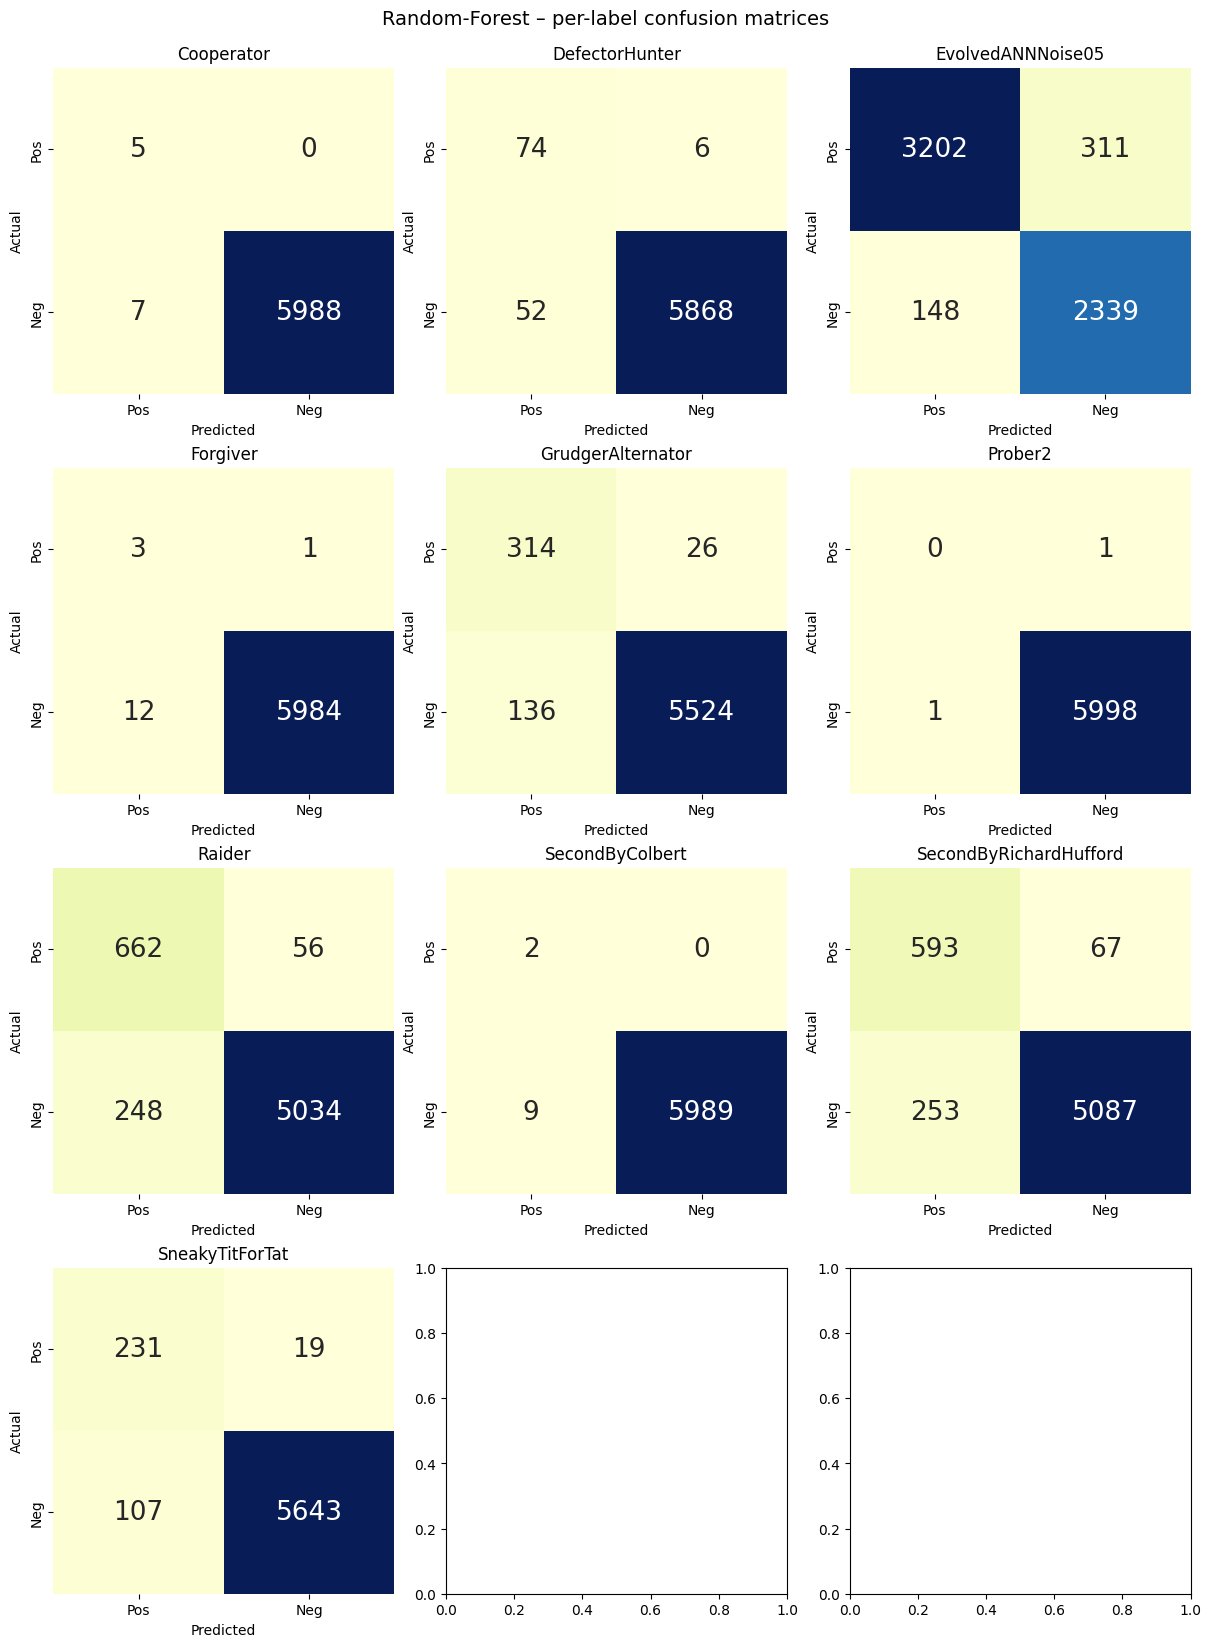

,precision,recall,f1,support
EvolvedANNNoise05,0.911,0.956,0.933,3350
Raider,0.922,0.727,0.813,910
SecondByRichardHufford,0.898,0.701,0.788,846
GrudgerAlternator,0.924,0.698,0.795,450
SneakyTitForTat,0.924,0.683,0.786,338
DefectorHunter,0.925,0.587,0.718,126
Forgiver,0.750,0.200,0.316,15
Cooperator,1.000,0.417,0.588,12
SecondByColbert,1.000,0.182,0.308,11
Prober2,0.000,0.000,0.000,1


In [22]:
# -------------------------------------------------------
# Random Forest
# -------------------------------------------------------
y_prob_rf = ovr_proba_to_matrix(rf_clf.predict_proba(X_test))
y_pred_rf = (y_prob_rf > 0.5).astype(int)

analyse_multilabel(y_test, y_pred_rf, mlb.classes_,
                   title_prefix="Random-Forest")

,precision,recall,f1,support
EvolvedANNNoise05,0.950000,0.966000,0.958000,3350
Raider,0.931000,0.884000,0.906000,910
SecondByRichardHufford,0.902000,0.835000,0.867000,846
GrudgerAlternator,0.928000,0.893000,0.911000,450
SneakyTitForTat,0.906000,0.858000,0.881000,338
DefectorHunter,0.861000,0.786000,0.822000,126
Forgiver,0.778000,0.467000,0.583000,15
Cooperator,1.000000,0.417000,0.588000,12
SecondByColbert,0.833000,0.455000,0.588000,11
Prober2,0.000000,0.000000,0.000000,1


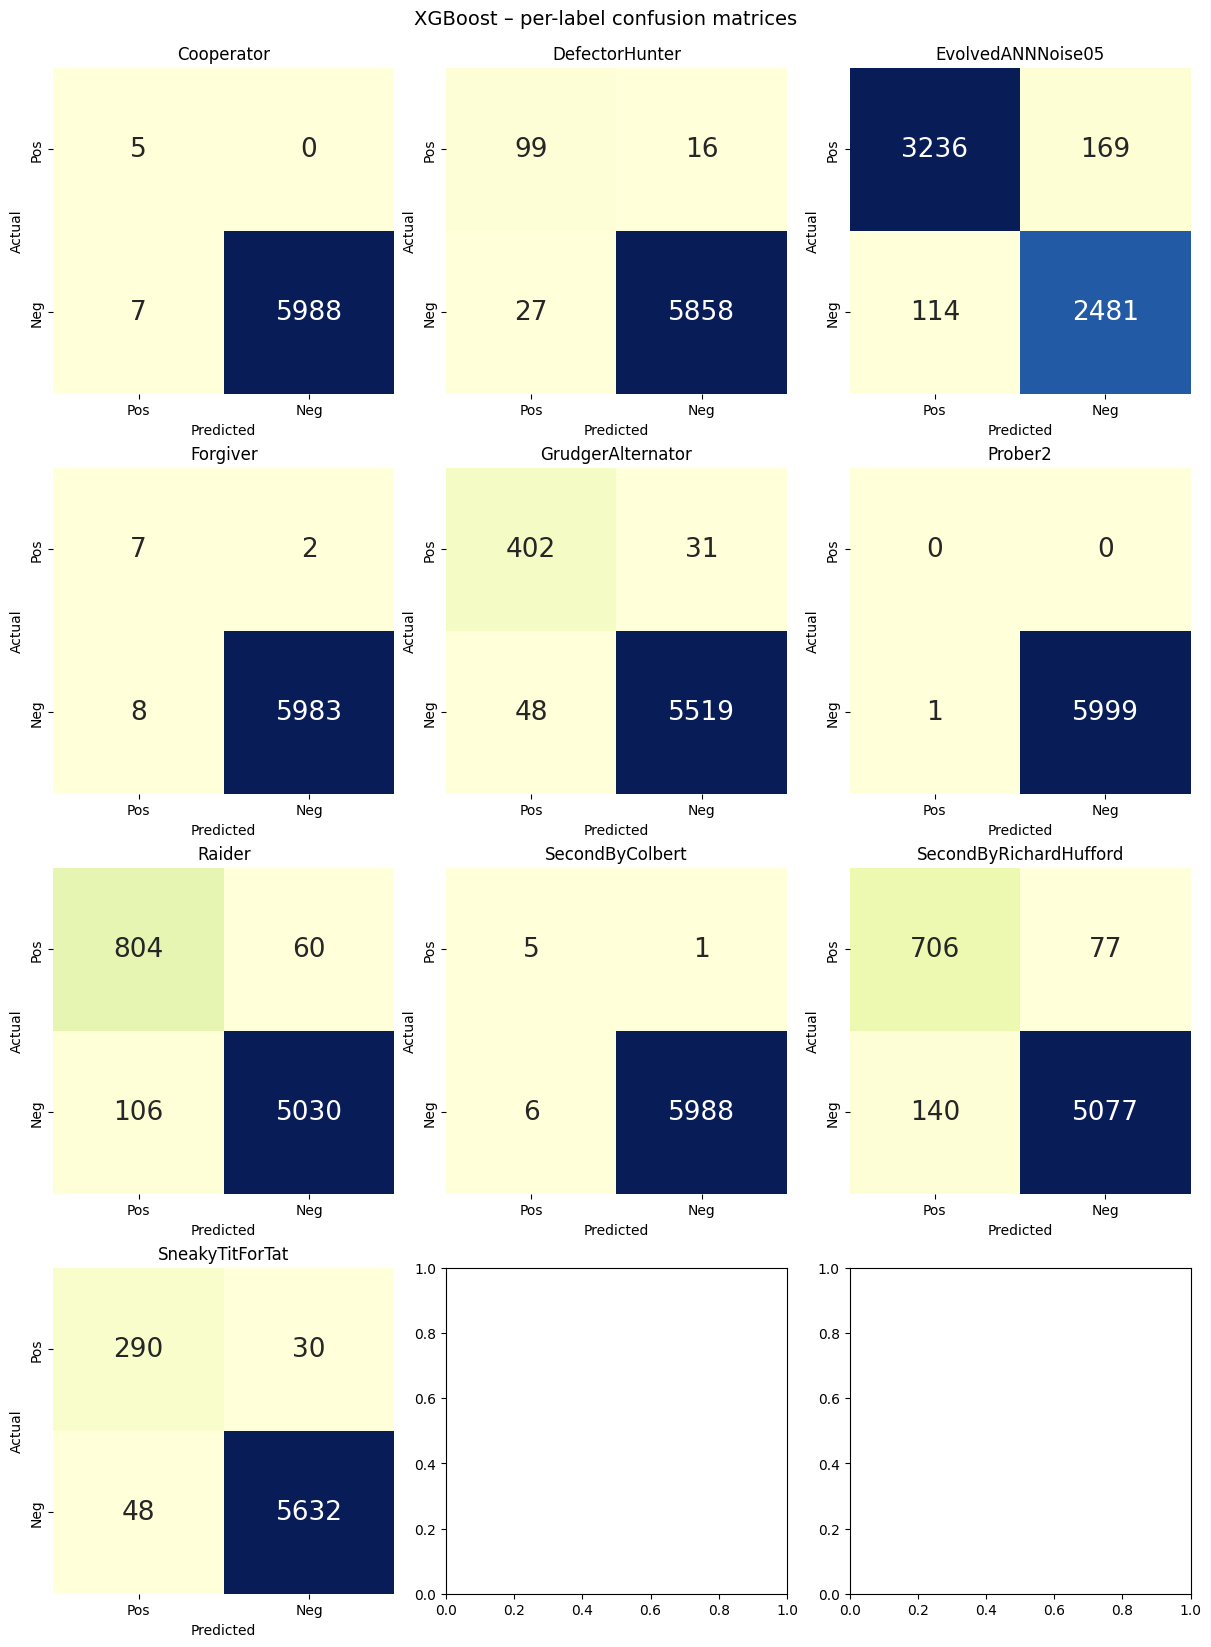

,precision,recall,f1,support
EvolvedANNNoise05,0.950,0.966,0.958,3350
Raider,0.931,0.884,0.906,910
SecondByRichardHufford,0.902,0.835,0.867,846
GrudgerAlternator,0.928,0.893,0.911,450
SneakyTitForTat,0.906,0.858,0.881,338
DefectorHunter,0.861,0.786,0.822,126
Forgiver,0.778,0.467,0.583,15
Cooperator,1.000,0.417,0.588,12
SecondByColbert,0.833,0.455,0.588,11
Prober2,0.000,0.000,0.000,1


In [23]:
y_prob_xgb = ovr_proba_to_matrix(xgb_clf.predict_proba(X_test))
y_pred_xgb = (y_prob_xgb > 0.5).astype(int)

analyse_multilabel(y_test, y_pred_xgb, mlb.classes_,
                   title_prefix="XGBoost")

,precision,recall,f1,support
EvolvedANNNoise05,0.983000,0.962000,0.972000,3350
Raider,0.966000,0.932000,0.949000,910
SecondByRichardHufford,0.944000,0.876000,0.909000,846
GrudgerAlternator,0.942000,0.900000,0.920000,450
SneakyTitForTat,0.963000,0.843000,0.899000,338
DefectorHunter,0.941000,0.254000,0.400000,126
Forgiver,0.000000,0.000000,0.000000,15
Cooperator,0.000000,0.000000,0.000000,12
SecondByColbert,0.000000,0.000000,0.000000,11
Prober2,0.000000,0.000000,0.000000,1


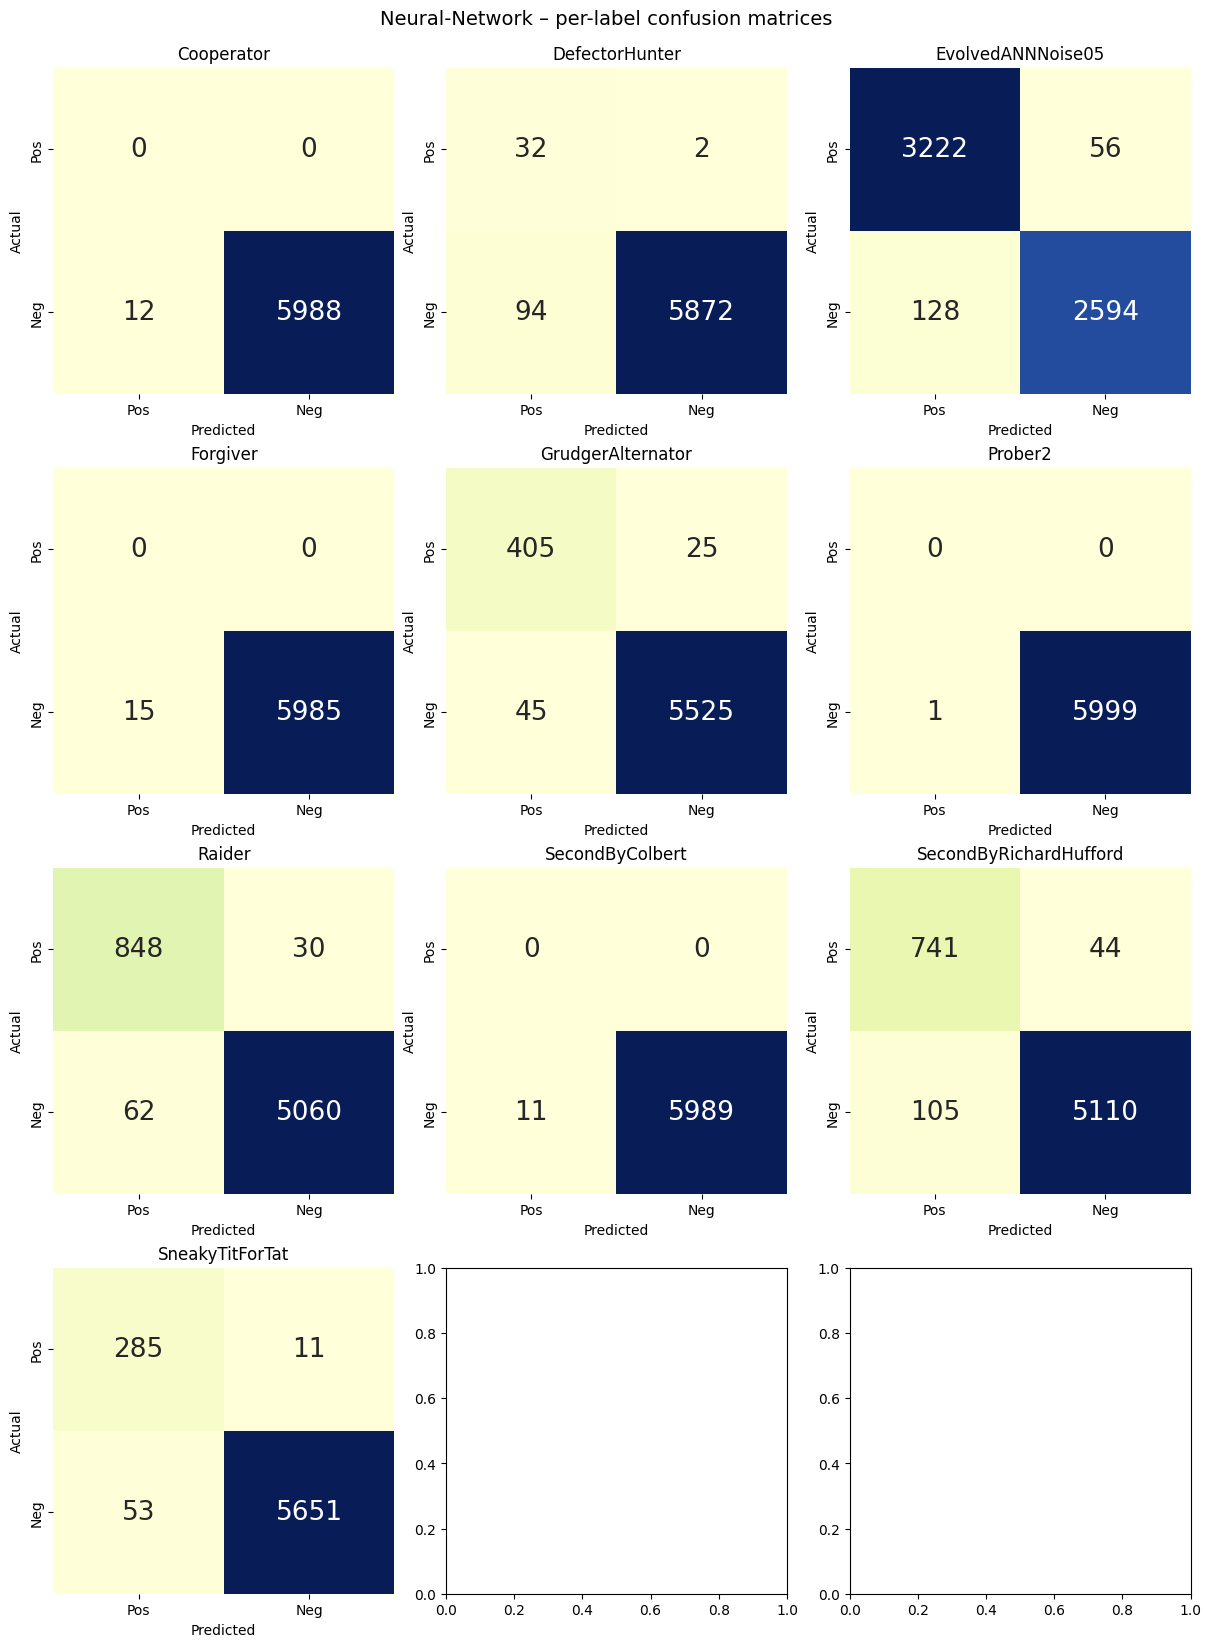

,precision,recall,f1,support
EvolvedANNNoise05,0.983,0.962,0.972,3350
Raider,0.966,0.932,0.949,910
SecondByRichardHufford,0.944,0.876,0.909,846
GrudgerAlternator,0.942,0.900,0.920,450
SneakyTitForTat,0.963,0.843,0.899,338
DefectorHunter,0.941,0.254,0.400,126
Forgiver,0.000,0.000,0.000,15
Cooperator,0.000,0.000,0.000,12
SecondByColbert,0.000,0.000,0.000,11
Prober2,0.000,0.000,0.000,1


In [24]:
y_prob_nn = nn_model.predict(X_test, verbose=0)
y_pred_nn = (y_prob_nn > 0.5).astype(int)

analyse_multilabel(y_test, y_pred_nn, mlb.classes_,
                   title_prefix="Neural-Network")